In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant, eta = eta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#samplenormal,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.samplenormal, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 1, 0, 0.1262135922330097, 2000, 500, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood", 0.001)

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)

loss: 0.29869568
likelihood: 0.23200272
KL: 0.084857784

loss: -1.8952364
likelihood: -1.9183986
KL: 0.00972319

loss: -1.8582028
likelihood: -1.9688257
KL: 0.10860567

loss: -2.202288
likelihood: -2.9037902
KL: 0.8178877

loss: -2.474116
likelihood: -3.683515
KL: 1.1343055

  7.218893 seconds (12.83 M allocations: 1.711 GiB, 5.57% gc time)
loss: -2.7441134
likelihood: -3.9377255
KL: 1.156929



2.188909f0

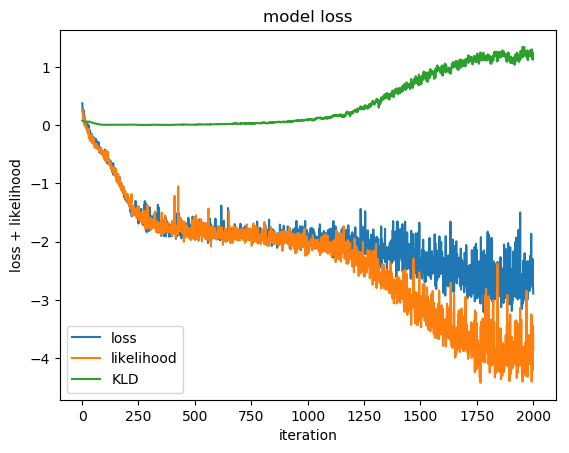

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
  0.687182   0.690553   0.748011  …   0.0341276   0.0396633   0.0287746
  0.695371   0.718274   0.761085      0.997759    0.982137    1.00243  
 -4.26564   -4.38461   -4.81641      -6.5694     -4.90339    -5.34342  
 -4.03368   -4.15167   -4.51571      -6.91417    -5.28253    -5.70131  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mux(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.653671  0.671951  0.673086  0.731878  …  0.0295368  0.0420249  0.0465423
 0.677334  0.690934  0.691768  0.705851     1.00135    0.997772   0.996526 

In [9]:
AnomalyDetection.sigma2x(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.0127177  0.0192063  0.0143001  …  0.00553888  0.00742432  0.00390344
 0.0158569  0.0181496  0.0156742     0.00388575  0.00513431  0.00247927

What are the parameters of $q(z|x)$?

In [10]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 -1.02245   -1.01481   -1.02829   …   1.20405    1.17177   1.12356 
  0.656123   0.649695   0.662422     -0.772642  -0.74923  -0.718086

In [11]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.242516  0.240272  0.243138  0.243352  …  0.198343  0.188892  0.191426
 0.585559  0.584756  0.587686  0.593689     0.448273  0.446873  0.447246

What do the codes look like?

In [12]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -1.39017  -0.81621   -0.937009  …   1.47999    0.667692   1.56799 
  1.68343   0.620984  -0.260804     -0.427572  -0.271004  -0.736864

In [13]:
# predict labels on testing data
model.M = 10 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 0
 1

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 10
  tn = 90
  fp = 0
  fn = 3
precision: 1.0
f1score: 0.8695652173913043
recall: 0.7692307692307693
false positive rate: 0.0
equal error rate: 0.11538461538461539

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
f1score: 0.9166666666666666
recall: 0.8461538461538461
false positive rate: 0.0
equal error rate: 0.07692307692307693


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 30);

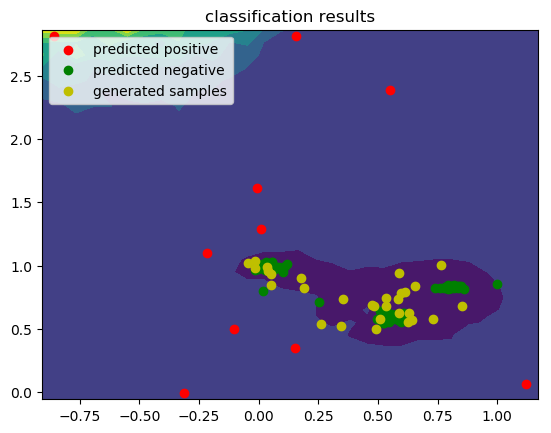

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

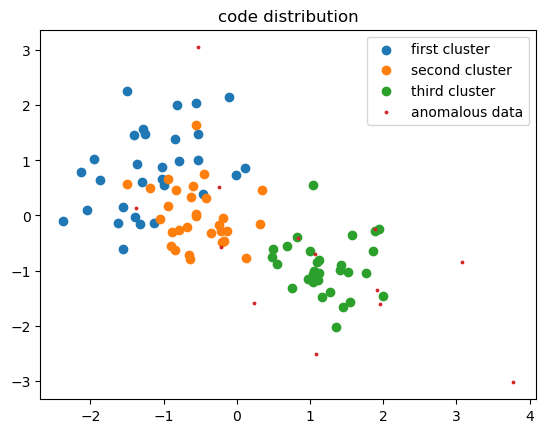

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

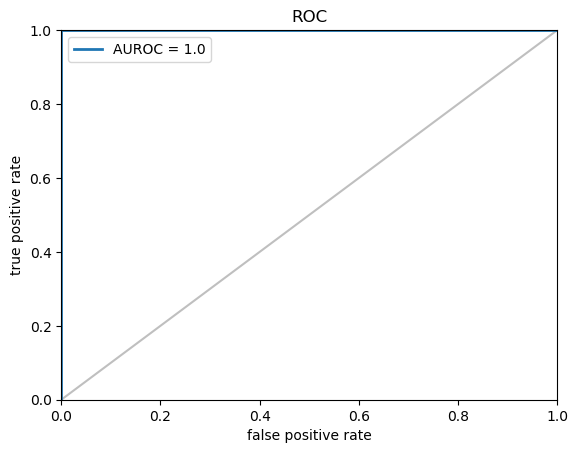

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()